In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import numpy as np 
import matplotlib.pyplot as plt
import json
import os 
from PIL import Image

In [2]:
import tqdm

In [3]:
tf.__version__

'2.9.0'

In [12]:
# use @tf.function wherever possible
# set global seed tf.random.set_seed(global_seed)


AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

TRAINING_FILENAMES = '../datasets/gazetrack_tfrec/train.tfrec'
VALID_FILENAMES = '../datasets/gazetrack_tfrec/val.tfrec'
TEST_FILENAMES = '../datasets/gazetrack_tfrec/test.tfrec'
BATCH_SIZE = 256

In [13]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "device": tf.io.FixedLenFeature([], tf.string),
        "screen_h": tf.io.FixedLenFeature([], tf.int64),
        "screen_w": tf.io.FixedLenFeature([], tf.int64),
        "face_valid": tf.io.FixedLenFeature([], tf.int64),
        "face_x": tf.io.FixedLenFeature([], tf.int64),
        "face_y": tf.io.FixedLenFeature([], tf.int64),
        "face_w": tf.io.FixedLenFeature([], tf.int64),
        "face_h": tf.io.FixedLenFeature([], tf.int64),
        "leye_x": tf.io.FixedLenFeature([], tf.int64),
        "leye_y": tf.io.FixedLenFeature([], tf.int64),
        "leye_w": tf.io.FixedLenFeature([], tf.int64),
        "leye_h": tf.io.FixedLenFeature([], tf.int64),
        "reye_x": tf.io.FixedLenFeature([], tf.int64),
        "reye_y": tf.io.FixedLenFeature([], tf.int64),
        "reye_w": tf.io.FixedLenFeature([], tf.int64),
        "reye_h": tf.io.FixedLenFeature([], tf.int64),
        "dot_xcam": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_cam": tf.io.FixedLenFeature([], tf.float32),
        "dot_x_pix": tf.io.FixedLenFeature([], tf.float32),
        "dot_y_pix": tf.io.FixedLenFeature([], tf.float32),
        "reye_x1": tf.io.FixedLenFeature([], tf.int64),
        "reye_y1": tf.io.FixedLenFeature([], tf.int64),
        "reye_x2": tf.io.FixedLenFeature([], tf.int64),
        "reye_y2": tf.io.FixedLenFeature([], tf.int64),
        "leye_x1": tf.io.FixedLenFeature([], tf.int64),
        "leye_y1": tf.io.FixedLenFeature([], tf.int64),
        "leye_x2": tf.io.FixedLenFeature([], tf.int64),
        "leye_y2": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    return example

In [14]:
def load_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False  # disable order, increase speed
    
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=AUTO)
  
    return dataset

In [15]:
loaded_dataset = load_dataset(VALID_FILENAMES)

lefteye shape: (103, 103, 3)
righteye shape: (103, 103, 3)


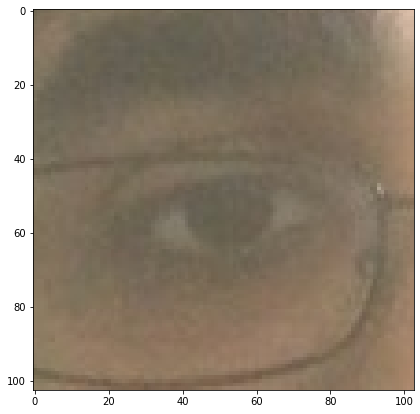

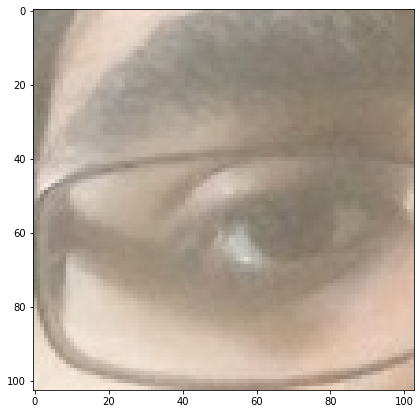

In [22]:
for i, features in enumerate(loaded_dataset.take(1)):
    image = features['image']
    
    lx, ly, lw, lh = features['leye_x'], features['leye_y'], features['leye_w'], features['leye_h']
    rx, ry, rw, rh = features['reye_x'], features['reye_y'], features['reye_w'], features['reye_h']
    
    lx, ly, lw, lh = tf.cast((lx, ly, lw, lh), tf.int32)
    rx, ry, rw, rh = tf.cast((rx, ry, rw, rh), tf.int32)
    
    l_eye = tf.image.crop_to_bounding_box(image, max(0, ly), max(0, lx), max(0, lh), max(0, lw))  
    r_eye = tf.image.crop_to_bounding_box(image, max(0, ry), max(0, rx), max(0, rh), max(0, rw))
    
    # l_eye = tf.image.transpose(l_eye)
    l_eye = tf.image.flip_left_right(l_eye)

    
    # l_eye = augmentation(l_eye)
    # r_eye = augmentation(r_eye)
    
    print(f"lefteye shape: {l_eye.shape}")
    print(f"righteye shape: {l_eye.shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(l_eye)
    plt.show()
    
    plt.figure(figsize=(7, 7))
    plt.imshow(r_eye)
    plt.show()

In [8]:
def augmentation(image, training = True):
    if training:
        aug = tf.keras.Sequential([
                layers.Resizing(128+10, 128+10),
                layers.RandomCrop(128, 128, 256),
                layers.Rescaling(1./255),
                layers.Normalization(mean = (0.3741, 0.4076, 0.5425), variance = (0.0004, 0.0004, 0.0004))
                ])
        
    else:
        aug = tf.keras.Sequential([
                layers.Resizing(128+10, 128+10),
                layers.Rescaling(1./255),
                layers.Normalization(mean = (0.3741, 0.4076, 0.5425), variance = (0.0004, 0.0004, 0.0004))
                ])
    
    image = aug(image)
    
    return image

In [99]:
def prepare_sample(features, train=True):
    image = features['image']
    w, h, _ = image.shape
    
    screen_w, screen_h = features['screen_w'], features['screen_h']
    
    kps = [features['leye_x1']/w, features['leye_y1']/h, features['leye_x2']/w, features['leye_y2']/h, 
           features['reye_x1']/w, features['reye_y1']/h, features['reye_x2']/w, features['reye_y2']/h]
    # kps has type float64
    

    lx, ly, lw, lh = features['leye_x'], features['leye_y'], features['leye_w'], features['leye_h']
    rx, ry, rw, rh = features['reye_x'], features['reye_y'], features['reye_w'], features['reye_h']
    
    lx, ly, lw, lh = tf.cast((lx, ly, lw, lh), tf.int32)
    rx, ry, rw, rh = tf.cast((rx, ry, rw, rh), tf.int32)
    
    l_eye = tf.image.crop_to_bounding_box(image, max(0, ly), max(0, lx), max(0, lh), max(0, lw))  
    r_eye = tf.image.crop_to_bounding_box(image, max(0, ry), max(0, rx), max(0, rh), max(0, rw))
    
    l_eye = tf.image.flip_left_right(l_eye)
    
    out = [features['dot_xcam'], features['dot_y_cam']]
    # out has type float32
    
    if train==True:
        # resize, randomcrop, normalize
        image = tf.image.resize(image, size=(128+10, 128+10))
        image = tf.image.stateless_random_crop(image, size=[128, 128, 3], seed=(256, 0))
        image = image/255.0
        
        pass
    
    
    
    else:
        # resize, normalize
        
        pass
    

    
    return l_eye, r_eye, kps, out, screen_w, screen_h

In [ ]:
def get_dataset(filenames):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTO)
        .map(prepare_sample, num_parallel_calls=AUTO)
        .shuffle(BATCH_SIZE * 10)
        .batch(BATCH_SIZE)
        .prefetch(AUTO)
    )
    
    return dataset

In [ ]:
for features in loaded_dataset.take(1): #reading first 1 values from the dataset
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

In [ ]:
# add transform code in this fn later

def transform_dataset(filenames):
    dataset = load_dataset(filenames)
    
    
    return dataset

In [ ]:
def get_batched_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(BATCH_SIZE*10)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTO)
    return dataset

In [ ]:
train_dataset = get_batched_dataset(TRAINING_FILENAMES)
valid_dataset = get_batched_dataset(VALID_FILENAMES)
test_dataset = get_batched_dataset(TEST_FILENAMES)

train_len = sum(1 for _ in tf.data.TFRecordDataset(TRAINING_FILENAMES))
val_len = sum(1 for _ in tf.data.TFRecordDataset(VALID_FILENAMES))
test_len = sum(1 for _ in tf.data.TFRecordDataset(TEST_FILENAMES))

print(f"No. of train samples: {train_len}")
print(f"No. of val samples: {val_len}")
print(f"No. of test samples: {test_len}")

In [ ]:
for features in train_dataset.take(2): #reading first 1 values from the dataset
    for key in features.keys():
        if key != "image":
            print(f"{key}: {features[key][255]}")

    print(f"Image shape: {features['image'][255].shape}")
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"][255].numpy())
    plt.show()